# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 29: Hierarchical Risk Parity (HRP) Portfolio Optimization with Constraints

## 1. Downloading the data:

In [3]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np
import warnings
import matplotlib as plt

warnings.filterwarnings("ignore")
plt.rc('font', family='Pretendard')
pd.options.display.float_format = '{:.4f}'.format

# Date range
start = '2010-01-01'
end = '2023-05-24'

# Tickers of assets
ticker_labes = {
    'ticker': ['^KS200', '229200.KS', '143850.KS', '195930.KS', '238720.KS', '192090.KS', '148070.KS', '136340.KS', '182490.KS', '280940.KS', '130680.KS', '114800.KS', '138230.KS', '139660.KS', '130730.KS'],
    'labels': ['KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300', '국채10년', '우량회사채', '해외채권', '금', 'WTI', 'KOSPI-Short', 'US-Long', 'US-Short', 'MMF']
}

# Downloading data
data = yf.download(ticker_labes['ticker'], start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data = data.dropna()

[*********************100%***********************]  15 of 15 completed


In [5]:
column_names = data.columns
matched_columns = [(label, ticker_labes['labels'][ticker_labes['ticker'].index(ticker)]) for label, ticker in column_names]

# Convert matched_columns to a pandas MultiIndex
matched_columns = pd.MultiIndex.from_tuples(matched_columns)

# Assign the matched columns to the prices dataframe
data.columns = matched_columns
data = data.sort_index(axis=1)

In [7]:
# Calculating returns
Y = data.pct_change().dropna()
Y = Y.droplevel(axis=1, level=0)
display(Y.head())

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
Date,,,,,,,,,,,,,,,
2017-11-10,0.016520,0.019814,-0.003500,0.003439,-0.000049,-0.007950,-0.002113,-0.009583,0.001310,-0.000448,0.003606,-0.000087,-0.003014,-0.000049,-0.000902
2017-11-13,0.003792,0.040048,-0.004852,0.004284,0.000049,-0.013937,-0.002443,-0.003366,0.003489,-0.003136,-0.002395,-0.003651,0.006549,-0.000980,0.000000
2017-11-14,-0.003778,0.038506,-0.002124,0.000853,-0.000049,-0.001060,-0.001143,-0.008020,-0.002173,0.002247,-0.006002,-0.001221,-0.001502,-0.000147,-0.003610
2017-11-15,-0.013543,0.026799,-0.004346,0.004263,0.000098,-0.014149,-0.000817,-0.007660,-0.005227,0.004484,-0.028986,0.001441,-0.002005,0.000245,0.000453
2017-11-16,-0.001098,0.018949,0.006593,-0.005093,-0.000049,0.012558,0.000000,0.004288,-0.009632,0.011607,0.007463,0.003358,0.003014,0.000736,-0.002263


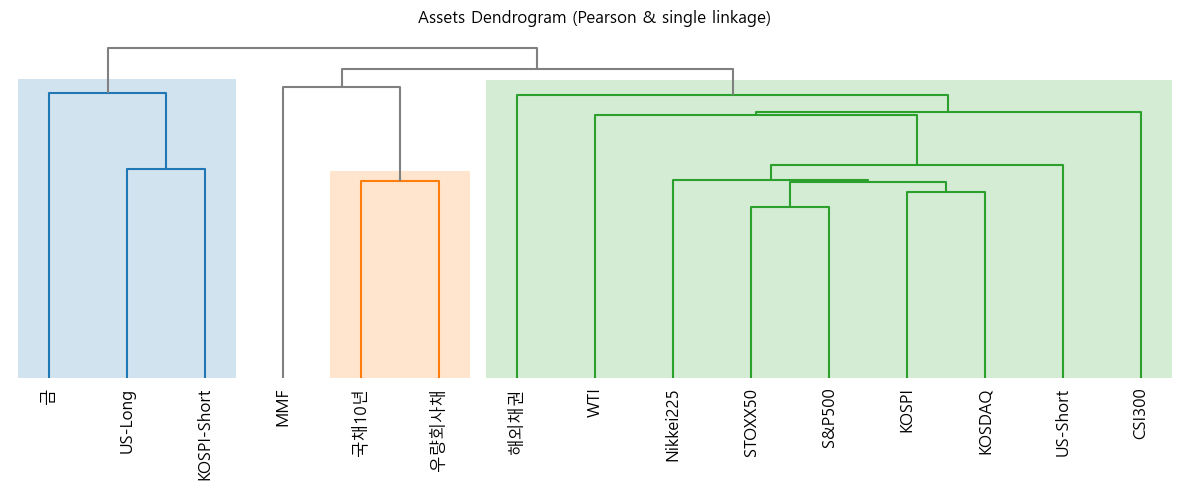

In [8]:
import riskfolio as rp

# Plotting Assets Clusters

ax = rp.plot_dendrogram(returns=Y,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

The dendrogram above suggest that optimal number of clusters are four. However HRP portfolios don't use a number of clusters as input.

## 2. Estimating HRP Portfolio

This is the original model proposed by López de Prado (2016). Riskfolio-Lib expand this model to 32 risk measures.

### 2.1 Calculating the HRP portfolio

In [9]:
# Building the portfolio object
port = rp.HCPortfolio(returns=Y)

# Estimate optimal portfolio:

model = 'HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
weights,0.000873,0.000294,0.000689,0.001657,0.60815,0.000796,0.000554,0.00054,0.008938,0.005078,0.000184,0.025868,0.004477,0.323654,0.018245


### 2.2 Plotting portfolio composition

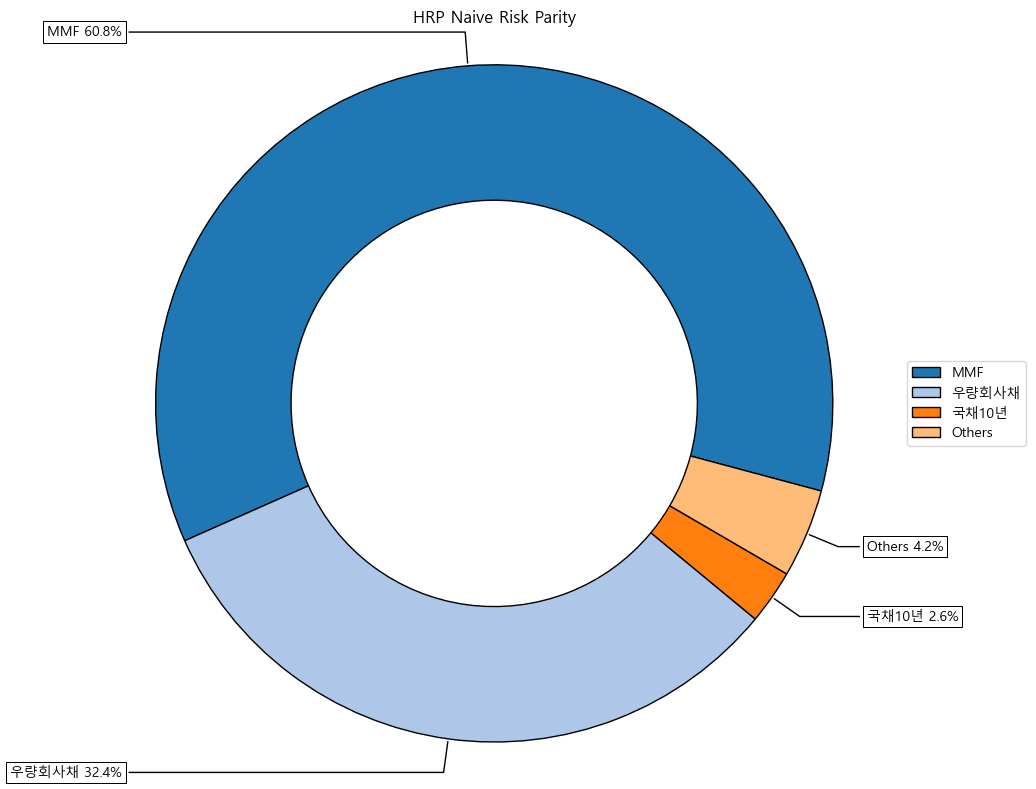

In [10]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

### 2.3 Plotting Risk Contribution

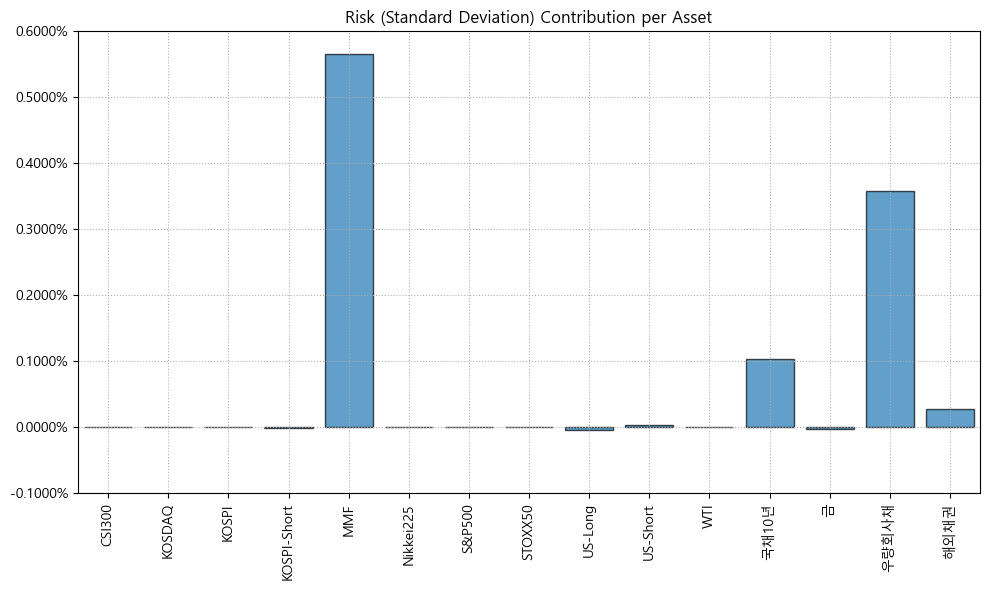

In [11]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

## 3. Estimating HRP Portfolio with Constraints

This is a modification of HRP model proposed by Johann Pfitzinger & Nico Katzke (2019).

### 3.1 Building the HRP portfolio constraints

In [37]:
Asset = ['KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300', '국채10년', '우량회사채', '해외채권', '금', 'WTI', 'KOSPI-Short', 'US-Long', 'US-Short', 'MMF']
Class = ['DS', 'DS', 'FS', 'FS', 'FS', 'FS', 'Bond', 'Bond', 'Bond', 'COM', 'COM', 'Inverse', 'FX', 'FX', 'Cash']
Disabled = [False] * 27
Type = ['Classes'] * 11 + ['Assets'] * 16
Set = ['Class'] * 11 + [''] * 16
Position = ['DS', 'DS', 'FS', 'FS', 'Bond', 'Bond', 'COM', 'COM', 'Inverse', 'FX', 'Cash',
            'KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300',
            '국채10년', '우량회사채', '해외채권',
            '금', 'WTI', 'KOSPI-Short', 'US-Long', 'US-Short',
            'MMF', '해외채권']
TypeRelative=  [''] * 27
RelativeSet =  [''] * 27
Relative = [''] * 27
Factor = [''] * 27

# DS상하한(2), FS상하한(2), Bond상하한(2), COM상하한(2), Inverse(1), FX(1), Cash(1)
# KOSPI상한, #KOSDAQ상한, S&P상한, STO상한, Nik상한, CSI상한,
# 국채상한, 회사채상한, 해채상한,
# 금, WTI, 코숏, 달러롱, 달러숏,
# 현금하한, 해채하한
Sign = ['<=', '>=', '<=', '>=', '<=', '>=', '<=', '>=', '<=', '<=', '<=', 
        '<=', '<=', '<=', '<=', '<=', '<=',
        '<=', '<=', '<=',
        '<=', '<=', '<=', '<=', '<=',
        '>=', '>=']

Weight = [0.40, 0.40, 0.40, 0.10, 0.60, 0.20, 0.20, 0.05, 0.20, 0.20, 0.50,
          0.40, 0.20, 0.20, 0.20, 0.20, 0.20,
          0.50, 0.40, 0.40,
          0.15, 0.15, 0.20, 0.20, 0.20,
          0.01, 0.05]

constraints_list = [Asset, Class, Disabled, Type, Set, Position, Sign, Weight]
for i in constraints_list:
    print(constraints_list.index(i) , len(i))

0 15
1 15
2 27
3 27
4 27
5 27
6 27
7 27


In [38]:
asset_classes = {'Assets': Asset,
                 'Class': Class
                 }

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': Disabled,
               'Type': Type,
               'Set': Set,
               'Position': Position,
               'Sign': Sign,
               'Weight': Weight,
}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight
0,False,Classes,Class,DS,<=,0.4000
1,False,Classes,Class,DS,>=,0.4000
2,False,Classes,Class,FS,<=,0.4000
3,False,Classes,Class,FS,>=,0.1000
4,False,Classes,Class,Bond,<=,0.6000
5,False,Classes,Class,Bond,>=,0.2000
6,False,Classes,Class,COM,<=,0.2000
7,False,Classes,Class,COM,>=,0.0500
8,False,Classes,Class,Inverse,<=,0.2000
9,False,Classes,Class,FX,<=,0.2000


### 3.2 Calculating the HRP portfolio with constraints

In [39]:
# Estimate optimal portfolio with constraints:

w_max, w_min = rp.hrp_constraints(constraints, asset_classes)

port.w_max = w_max
port.w_min = w_min

w_1 = port.optimization(model=model,
                        codependence=codependence,
                        rm=rm,
                        rf=rf,
                        linkage=linkage,
                        max_k=max_k,
                        leaf_order=leaf_order)

display(w_1.T)

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
weights,0.0000,0.0000,0.0000,0.0097,0.4835,NaN,0.0483,0.0000,0.0002,0.0000,NaN,0.1042,0.0042,0.3000,0.0500


### 3.3 Plotting portfolio composition

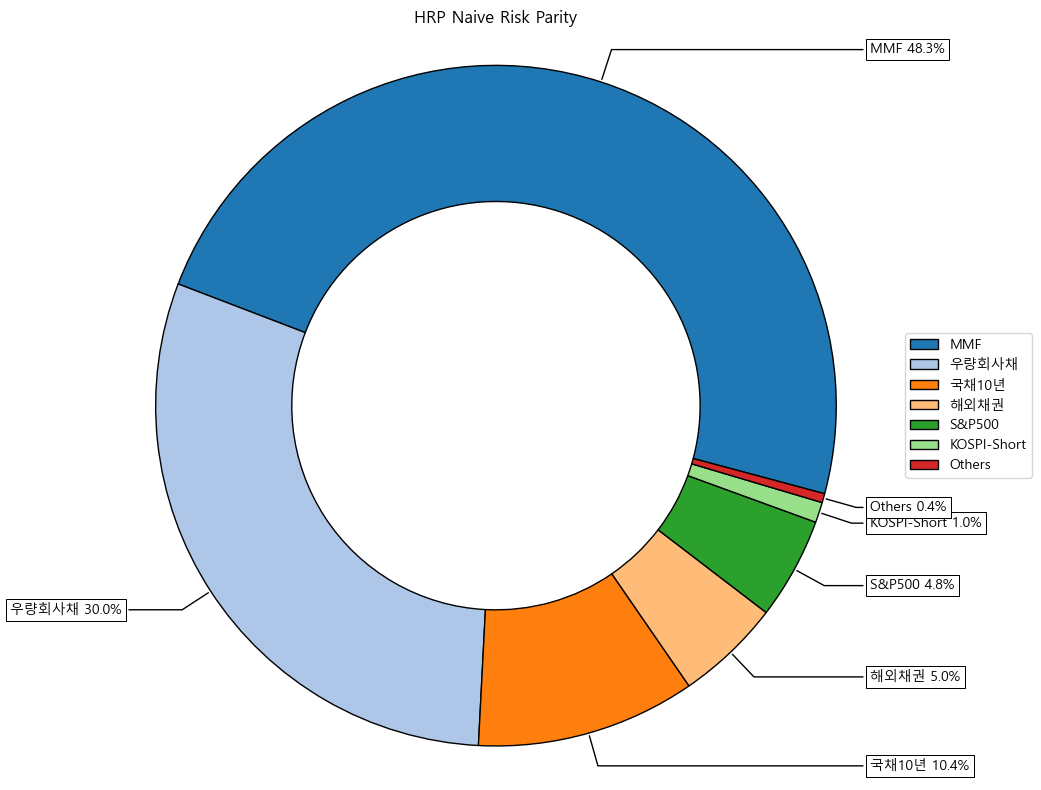

In [41]:
# Plotting the composition of the portfolio with constraints

ax = rp.plot_pie(w=w_1,
                 title='HRP Naive Risk Parity',
                 others=0.01,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

In [42]:
pd.options.display.float_format = '{:.4f}'.format
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
display(w_classes)

w_classes = w_classes.groupby(['Class']).sum()
display(w_classes)

,Class,weights
CSI300,FS,0.0009
KOSDAQ,DS,0.0003
KOSPI,DS,0.0007
KOSPI-Short,Inverse,0.0017
MMF,Cash,0.6081
Nikkei225,FS,0.0008
S&P500,FS,0.0006
STOXX50,FS,0.0005
US-Long,FX,0.0089
US-Short,FX,0.0051


,weights
Class,
Bond,0.3678
COM,0.0047
Cash,0.6081
DS,0.0010
FS,0.0028
FX,0.0140
Inverse,0.0017


### 3.4 Plotting Risk Contribution

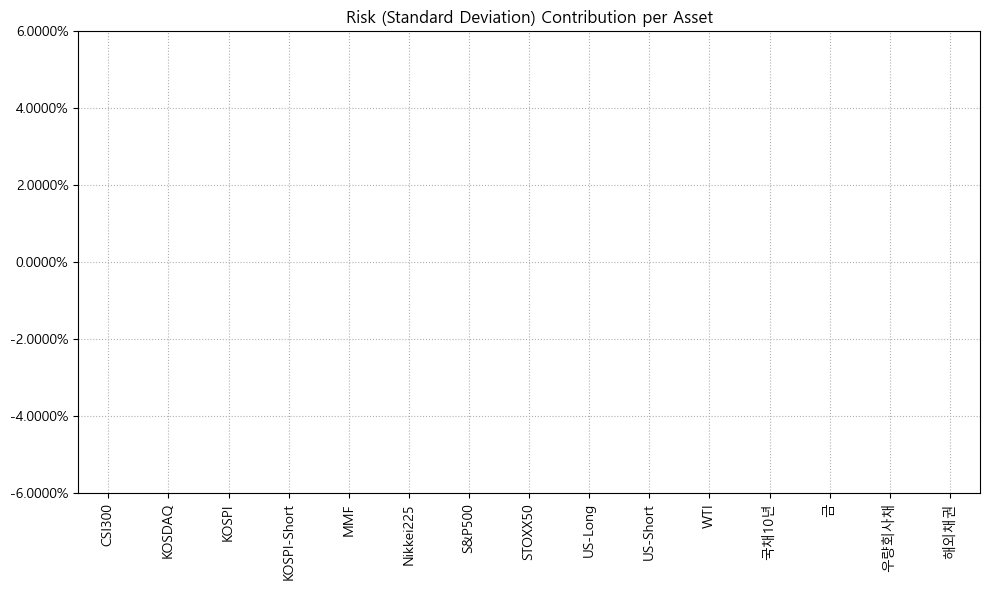

In [26]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w_1,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)